In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [35]:
# Step 1: Merge the datasets
# Merge customer data with transaction data
merged_data = transactions.merge(customers, on='CustomerID')

In [36]:
# Step 2: Feature Engineering
# Create aggregated features for each customer based on transactions
customer_profile = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    unique_products_bought=('ProductID', 'nunique')
).reset_index()

In [37]:
# Convert 'SignupDate' to datetime and calculate customer tenure in years
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['Tenure'] = (pd.to_datetime('today') - customers['SignupDate']).dt.days / 365

In [38]:
# Merge the aggregated transaction features with the customer profile (Region, Tenure)
customer_profile = customer_profile.merge(customers[['CustomerID', 'Region', 'Tenure']], on='CustomerID')

In [39]:
# Step 3: Normalize the data (scaling numerical features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_profile[['total_spent', 'num_transactions', 'avg_transaction_value', 'unique_products_bought', 'Tenure']])

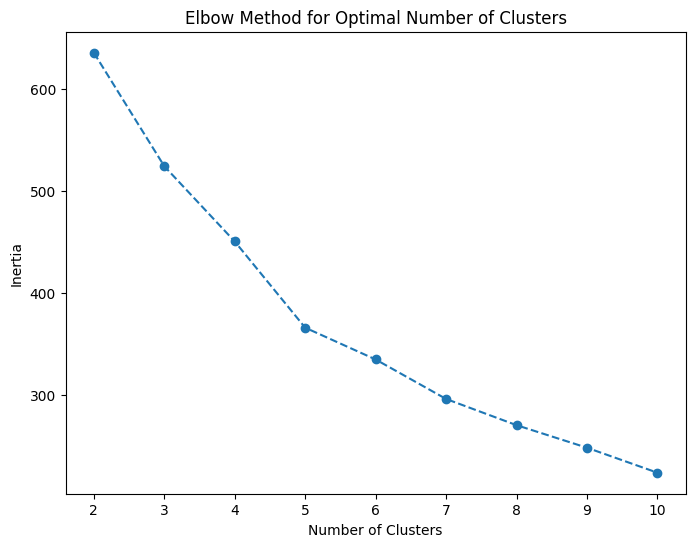

In [55]:
#Elbow Method to find the optimal number of clusters
inertia_values = []
cluster_range = range(2, 11)  # Trying clusters from 2 to 10
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [67]:
# Step 4: Clustering using KMeans (Choosing number of clusters between 2 and 10)
# You can experiment with different cluster counts, here we use KMeans with 5 clusters
kmeans = KMeans(n_clusters=10, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)

In [68]:
# Step 5: Evaluation - Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
print(f'Davies-Bouldin Index: {db_index:.3f}')

Davies-Bouldin Index: 1.074


In [69]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, v_measure_score
# Silhouette Score
sil_score = silhouette_score(scaled_features, customer_profile['Cluster'])
print(f'Silhouette Score: {sil_score:.3f}')




Silhouette Score: 0.280


In [70]:
# V-Measure (similar to ARI but considers homogeneity and completeness)
v_measure = v_measure_score(customer_profile['Region'], customer_profile['Cluster'])  # Assuming 'Region' is a ground truth
print(f'V-Measure: {v_measure:.3f}')



V-Measure: 0.049


In [71]:
# Inertia (Sum of squared distances of samples to their closest cluster center)
inertia = kmeans.inertia_
print(f'Inertia: {inertia:.3f}')

Inertia: 223.438


In [72]:
# Step 6: Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

In [73]:
# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_profile['Cluster']

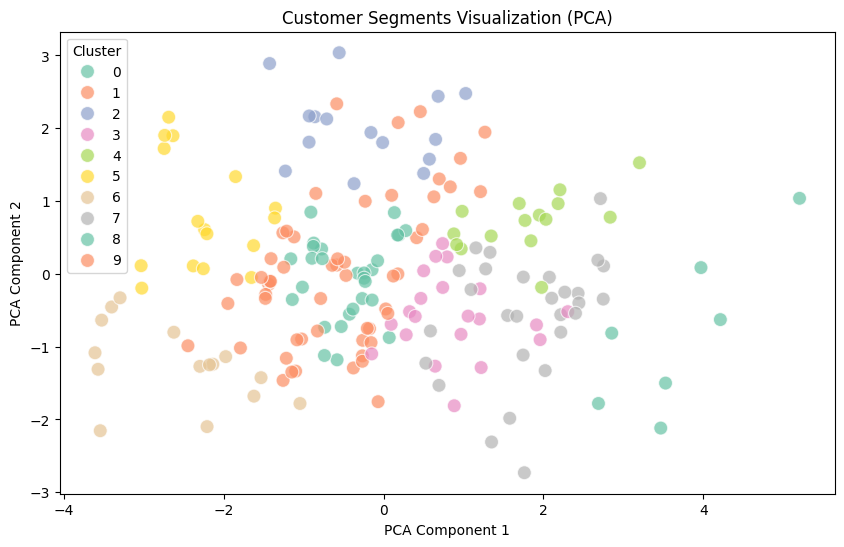

In [74]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', palette='Set2', data=pca_df, s=100, alpha=0.7)
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

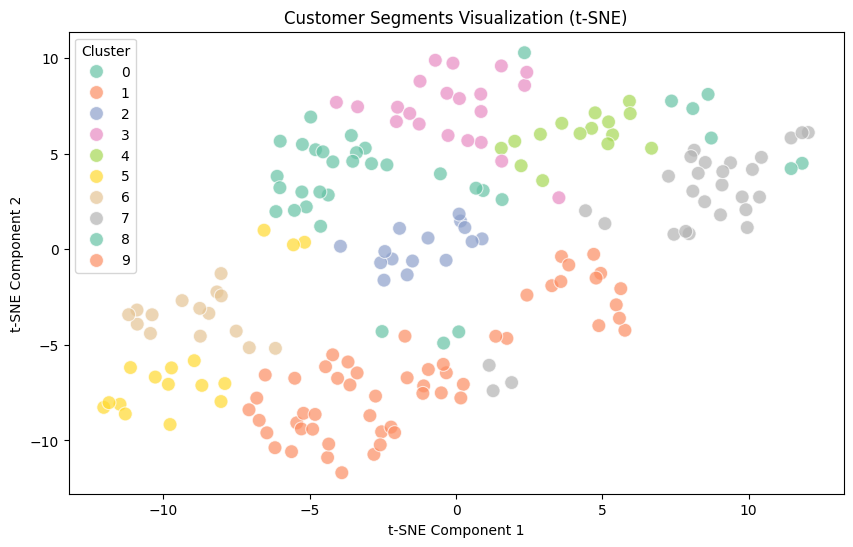

In [75]:
from sklearn.manifold import TSNE
# t-SNE Visualization (2D Projection)
tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(scaled_features)
tsne_df = pd.DataFrame(data=tsne_components, columns=['tSNE1', 'tSNE2'])
tsne_df['Cluster'] = customer_profile['Cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', palette='Set2', data=tsne_df, s=100, alpha=0.7)
plt.title('Customer Segments Visualization (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

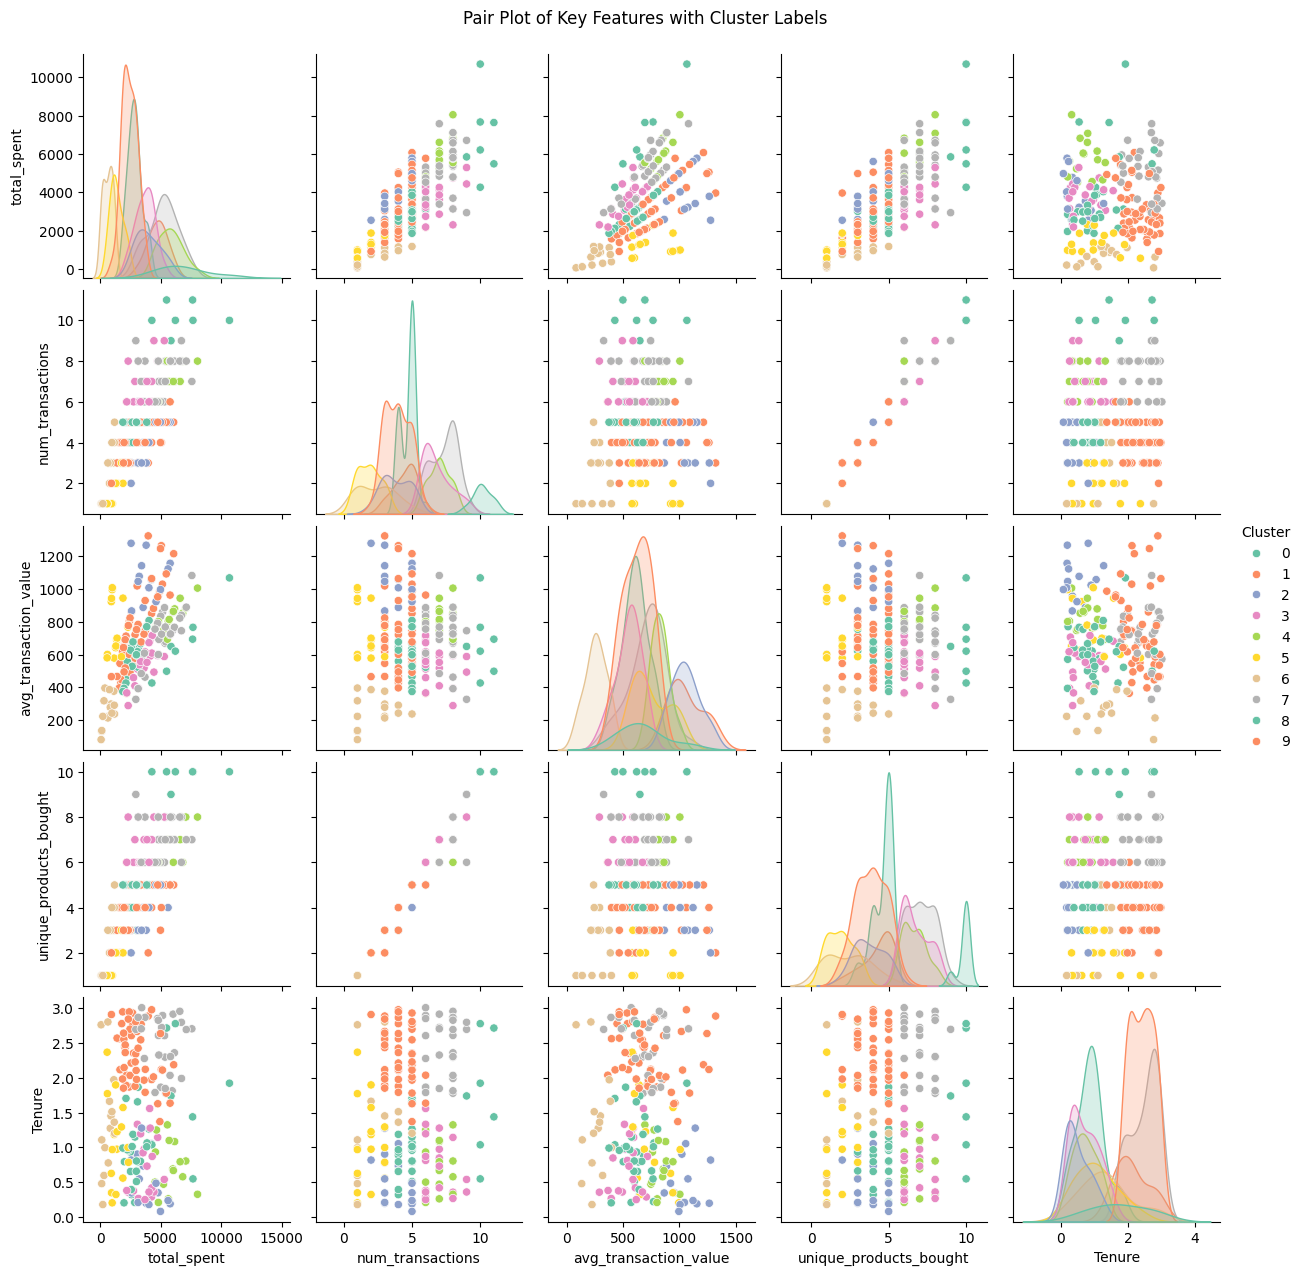

In [76]:
# Pair Plot of Key Features
sns.pairplot(customer_profile[['total_spent', 'num_transactions', 'avg_transaction_value', 'unique_products_bought', 'Tenure', 'Cluster']],
             hue='Cluster', palette='Set2')
plt.suptitle('Pair Plot of Key Features with Cluster Labels', y=1.02)
plt.show()

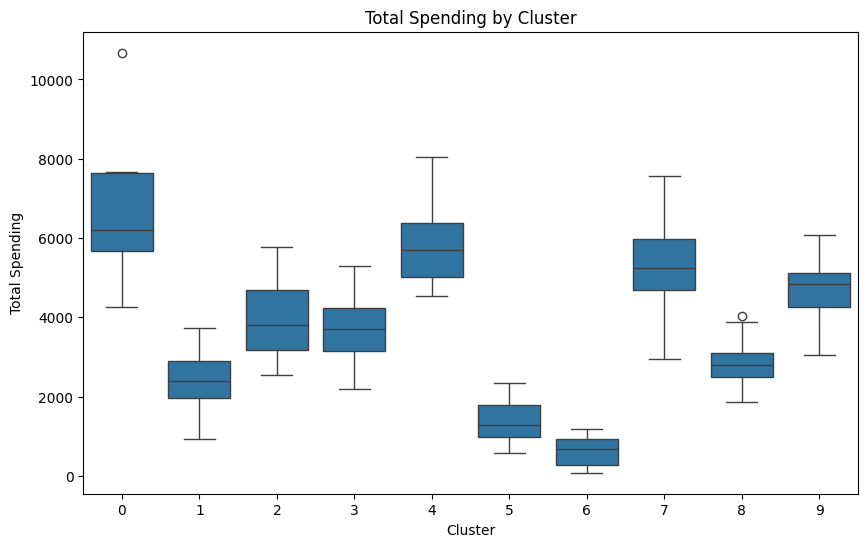

In [77]:
# Cluster Distribution by Features (Example: total_spent)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='total_spent', data=customer_profile)
plt.title('Total Spending by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spending')
plt.show()

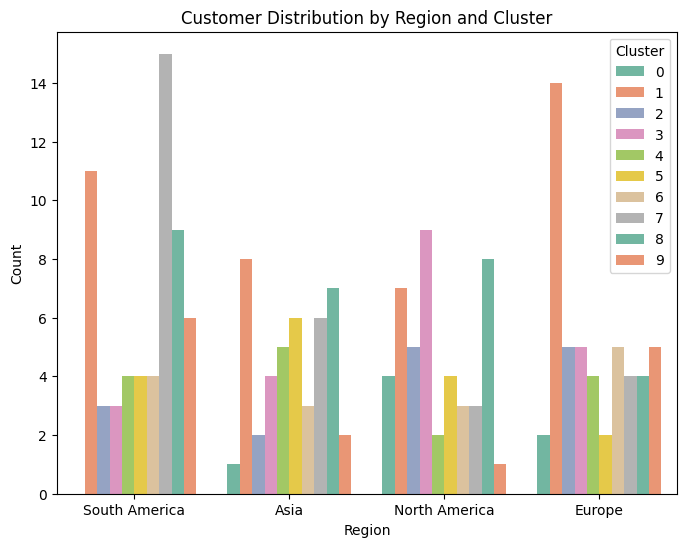

In [78]:
# Visualize customer distribution across regions
plt.figure(figsize=(8, 6))
sns.countplot(x='Region', hue='Cluster', data=customer_profile, palette='Set2')
plt.title('Customer Distribution by Region and Cluster')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()